### Imports

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib
import numpy as np

In [4]:
import logging
import os
import sys
import datetime as dt
from typing import List, Union, Optional
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.encoding.tools import create_encoding_pipeline
from src.experiments.features_selection import get_features, explore_features
from src.models.sklearn_api_model import Model, ModelTree
import src.features as ft
import mlflow.sklearn
import mlflow
import mlflow.data.pandas_dataset
from mlflow.models import infer_signature
import os
import matplotlib.pyplot as plt
%matplotlib widget
import cudf as cd
import numpy as np
import re


### Config

In [5]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [6]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

##### Encoding Pipeline

In [7]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [8]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [9]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7434789571c0>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x743478956a10>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x743478957160>)],
                  verbose=True)

##### Dataset

In [10]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    # "locations": ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon', 'CH Langres', 'CH Chaumont', 'HNFC', 'CHU Besançon']
    "locations": ['CHU Dijon']
    }

In [11]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [ ]:
# Define the configuration of the dataset
get_dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    # 'axis': 'rows',
    'shift': range(1, 8, 1),
    # 'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False},
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': ['nb_emmergencies'],
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    }

In [13]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config)

root 2024-11-15 12:46:09,723: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-15 12:46:09,728: INFO: Initialisation des features
root 2024-11-15 12:46:09,732: INFO: Fetching dataset
root 2024-11-15 12:46:10,039: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:10,322: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:10,564: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:10,896: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:11,200: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:11,511: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:11,889: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-15 12:46:12,246: INFO: trafficfeatures's data already fetched for CHU Dijon


In [14]:
# df = arsTabularDataset.enc_data

# # Identifie les colonnes contenant des NaN
# cols_with_nan = df.columns[df.isna().any()].tolist()
# print("Colonnes contenant des NaN:", cols_with_nan)

# # Affiche la liste des index des lignes contenant des NaN pour chaque colonne
# nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
# nan_indices

In [15]:
# df

In [16]:
# df.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{get_dataset_config['locations']}.csv')
# df_target = arsTabularDataset.data[arsTabularDataset.targets_names]
# df_target.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{get_dataset_config['locations']}_targets.csv')

##### Model

In [17]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
from src.models.obectives import *
model_params = {
    # 'tree_method': 'approx',
    # 'tree_method': 'hist',
    'early_stopping_rounds': 10,
    # 'eval_set': [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)], # TODO: to be set in the experiment's run method
    'verbosity': 1,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'subsample': 0.7, 
    'colsample_bytree': 0.7,
    # 'huber_slope': 1.0,
    # 'quantile_alpha': np.array([0.5]),
    'objective': 'reg:squarederror',
    # 'tweedie_variance_power': 2,
    # 'alpha': 10
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree' 
}

In [18]:
metrics = ['mae', 'mse', 'rmse', 'w_rmse', 'pw_rmse', 'msle', 'rmsle', 'r2', 'mqe', 'msse', 'max_error', 'explained_variance']

In [19]:
# Create the model
model = get_model(model_type='xgboost', name='XGBoost', device='cuda', task_type='regression', test_metrics=metrics, params=model_params)

rmse


In [20]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model, name='target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J')

In [21]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 4, 5, 7, 9],
    'gamma' : [0.01, 0.05, 0.1, 0.2, 0.3]
}

In [22]:
fit_params = {
    'verbose': 1,
}

In [23]:
from sklearn.model_selection import TimeSeriesSplit

In [24]:
model_config={"optimization": "grid", "grid_params": grid_params, "fit_params": fit_params, 'cv_folds': TimeSeriesSplit()}

### Start run

In [25]:
find_best_features = False

2024/11/15 12:47:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-11-15 12:47:00,508: INFO: Running the experiment...
root 2024-11-15 12:47:00,853: INFO: Getting the dataset from 01-01-2019 to 30-12-2023 for CHU Dijon
root 2024-11-15 12:47:01,174: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-15 12:47:01,179: INFO: Augmentation des features...
root 2024-11-15 12:47:01,184: INFO: Getting data for airqualityfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-15 12:47:01,200: INFO: Augmentation des features...
root 2024-11-15 12:47:01,241: INFO: Getting data for epidemiologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-15 12:47:01,248: INFO: Augmentation des features...
root 2024-11-15 12:47:01,265: INFO: Getting data for googletrendfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00

            nb_emmergencies  nb_emmergencies%%J-1  nb_emmergencies%%J-2  \
date                                                                      
2019-01-01              202                 202.0                 202.0   
2019-01-02              198                 202.0                 202.0   
2019-01-03              186                 198.0                 202.0   
2019-01-04              186                 186.0                 198.0   
2019-01-05              204                 186.0                 186.0   
...                     ...                   ...                   ...   
2023-12-26              177                 187.0                 177.0   
2023-12-27              165                 177.0                 187.0   
2023-12-28              192                 165.0                 177.0   
2023-12-29              157                 192.0                 165.0   
2023-12-30              212                 157.0                 192.0   

            nb_emmergenc

root 2024-11-15 12:47:02,277: INFO: 30 features not encoded (same unit as target)


[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.1s
[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.0s


Scoring using:  make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
[0]	validation_0-rmse:16.21890
[1]	validation_0-rmse:16.13978
[2]	validation_0-rmse:16.09509
[3]	validation_0-rmse:16.17548
[4]	validation_0-rmse:15.97901
[5]	validation_0-rmse:15.91242
[6]	validation_0-rmse:15.95068
[7]	validation_0-rmse:15.88917
[8]	validation_0-rmse:15.72385
[9]	validation_0-rmse:15.69583
[10]	validation_0-rmse:15.65954
[11]	validation_0-rmse:15.70106
[12]	validation_0-rmse:15.84287
[13]	validation_0-rmse:15.68333
[14]	validation_0-rmse:15.70112
[15]	validation_0-rmse:15.62325
[16]	validation_0-rmse:15.59031
[17]	validation_0-rmse:15.57613
[18]	validation_0-rmse:15.55980
[19]	validation_0-rmse:15.38718
[20]	validation_0-rmse:15.38844
[21]	validation_0-rmse:15.36412
[22]	validation_0-rmse:15.31488
[23]	validation_0-rmse:15.21351
[24]	validation_0-rmse:15.17492
[25]	validation_0-rmse:15.18475
[26]	validation_0-rmse:15.13480
[27]	validation_0-rmse:15.15099
[28]	vali

root 2024-11-15 12:50:51,786: INFO: Model fitted.
root 2024-11-15 12:50:51,795: INFO: Testing the model...
root 2024-11-15 12:50:52,344: INFO: Scoring the model...
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



Scoring with mae
Scoring with mse
Scoring with rmse
Scoring with w_rmse
Scoring with pw_rmse
Scoring with msle
Scoring with rmsle
Scoring with r2
Scoring with mqe
Scoring with msse
Scoring with max_error
Scoring with explained_variance
{'mae': 10.629209329793742, 'mse': 182.50303809729124, 'rmse': 13.509368530663869, 'w_rmse': 20.240280723077824, 'pw_rmse': 20.911866324512022, 'msle': 0.005869476281123823, 'rmsle': 0.07661250734132008, 'r2': 0.021300535645731644, 'mqe': 107833.62863597847, 'msse': 75.23727568328607, 'max_error': 50.29131062825522, 'explained_variance': 0.03796704678665663}


root 2024-11-15 12:50:56,611: INFO: Plotting the results...
matplotlib.legend 2024-11-15 12:50:56,631: WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


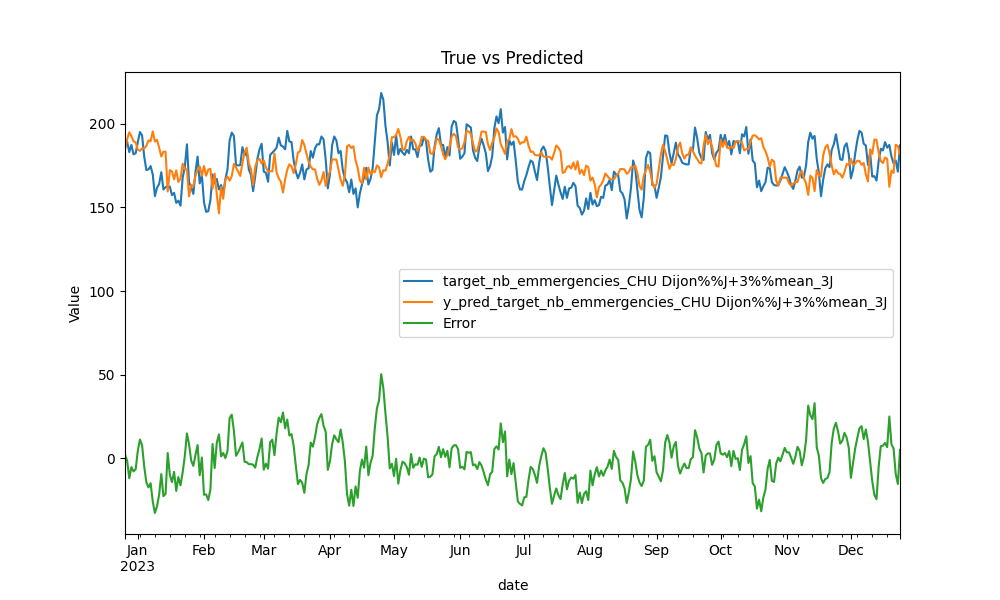

In [26]:
run = mlflow.start_run(run_name='run_' + str(ars_experiment.run_nb), log_system_metrics=True)
run_dir = ars_experiment.dir_runs / f'{run.info.run_id}/artifacts/'
run_dir = pathlib.Path(run_dir)
ars_experiment.logger.info("Running the experiment...")
ars_experiment.dataset.get_dataset(**get_dataset_config)
# Certain fit_params doivent être initialisés après la création des datasets : eval_set
model_config['fit_params'].update({'eval_set': [(
    ars_experiment.dataset.enc_X_val, ars_experiment.dataset.y_val[target]) for target in ars_experiment.dataset.targets_names]})

mlflow.log_table(data=ars_experiment.dataset.data,
                artifact_file='datasets/full_dataset.json')
if find_best_features:
    if isinstance(find_best_features, bool):
        # selected_features = ars_experiment.get_important_features(dataset=dataset, model=ars_experiment.model, model_config=model_config)
        selected_features = ['nb_emmergencies%%J-7', 'nb_emmergencies%%J-1', 'nb_emmergencies%%J-2','nb_emmergencies%%J-3',
                            'nb_emmergencies', 'NO2_FR26094%%mean_7J', 'nb_emmergencies%%mean_365J', 'eveBankHolidays',
                            'meteo_wdir%%J-7', 'confinement1', 'trend_grippe%%mean_7J', 'trend_hopital%%J-3', 'trend_vaccin%%J-2',
                            'inc_diarrhee%%J-7', 'PM25_FR26094%%J-7', 'trend_crampes abdominales%%J-7', 'trend_médecin',
                            'trend_crampes abdominales%%mean_7J', 'confinement2', 'NO2_FR26010', 'trend_hopital%%J-2', 'trend_mal de tête%%mean_7J',
                            'trend_paralysie%%J-7', 'trend_accident de voiture%%mean_7J', 'trend_paralysie%%mean_7J', 'meteo_tavg%%mean_7J',
                            'trend_insuffisance cardiaque', 'trend_fièvre%%J-7', 'trend_infection respiratoire%%mean_7J']
        selected_features.extend(['PM10_FR26005%%mean_31J', 'foot%%std_14J', 'inc_ira%%mean_31J', 
                            'meteo_tmin%%mean_31J', 'trend_vaccin%%mean_31J', 'confinement2',
                            'meteo_tmax%%mean_31J', 'after_HNFC_moving', 'trend_vaccin%%mean_14J',
                            'trend_hopital%%mean_31J', 'trend_hopital%%mean_14J', 'date##week_cos',
                            'O3_FR26010%%mean_31J', 'O3_FR26005%%mean_31J', 'meteo_tavg%%mean_31J',
                            'inc_grippe%%mean_31J', 'inc_grippe%%mean_14J', 'date##week_sin',
                            'date##dayofYear_sin', 'confinement1'])
        selected_features = ['nb_emmergencies_CHU Dijon', 'nb_emmergencies_CHU Dijon%%J-1',
        'nb_emmergencies_CHU Dijon%%J-2', 'nb_emmergencies_CHU Dijon%%J-3',
        'nb_emmergencies_CHU Dijon%%J-4', 'nb_emmergencies_CHU Dijon%%J-5',
        'nb_emmergencies_CHU Dijon%%J-6', 'nb_emmergencies_CHU Dijon%%J-7',
        'nb_emmergencies_CHU Dijon%%J-8', 'nb_emmergencies_CHU Dijon%%J-9',
        'nb_emmergencies_CHU Dijon%%J-10', 'nb_emmergencies_CHU Dijon%%J-11',
        'nb_emmergencies_CHU Dijon%%J-12', 'nb_emmergencies_CHU Dijon%%J-13',
        'nb_emmergencies_CHU Dijon%%mean_7J',
        'nb_emmergencies_CHU Dijon%%mean_14J', 'inc_diarrhee', 'inc_ira',
        'inc_diarrhee%%J-1', 'inc_diarrhee%%J-2', 'inc_diarrhee%%J-3',
        'inc_ira%%J-1', 'inc_ira%%J-2', 'inc_ira%%J-3', 'inc_ira%%J-4',
        'inc_ira%%J-5', 'inc_ira%%J-6', 'inc_ira%%J-8', 'inc_ira%%J-9',
        'inc_ira%%J-10', 'inc_ira%%J-11', 'inc_ira%%J-12', 'inc_ira%%J-13',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-7',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-8',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-9',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-10',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-11',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-12',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-13',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6',
        'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6',
        'date##week##cat##target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J']
    elif isinstance(find_best_features, List):
        selected_features = find_best_features
    elif isinstance(find_best_features, str):
        selected_features = [find_best_features]
    else:
        raise ValueError('find_best_features must be a bool, a list or a string')

    if get_dataset_config['axis'] == 'columns':
        for loc in get_dataset_config['locations']:
            selected_features = [feat + '_' + loc.name if not feat.endswith(loc.name) else feat for feat in selected_features]
    elif get_dataset_config['axis'] == 'rows' and 'location' not in ars_experiment.dataset.columns.to_list():
        selected_features.append('location')

    # selected_features = dataset.enc_X_train.columns.to_list()
    get_dataset_config['features_names'] = selected_features
    ars_experiment.logger.info(
        'Features selected: {}'.format(selected_features))
    ars_experiment.dataset.get_dataset(**get_dataset_config)
    mlflow.log_table(data=ars_experiment.dataset.data,
                    artifact_file='datasets/full_dataset_feature_selection.json')
    model_config['fit_params']['eval_set'] = [
        (ars_experiment.dataset.enc_X_val, ars_experiment.dataset.y_val[target]) for target in ars_experiment.dataset.targets_names]

mlflow.log_table(data=ars_experiment.dataset.train_set,
                    artifact_file='datasets/train_set.json')
mlflow.log_table(data=ars_experiment.dataset.val_set,
                    artifact_file='datasets/val_set.json')
mlflow.log_table(data=ars_experiment.dataset.test_set,
                    artifact_file='datasets/test_set.json')

train_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.train_set)
val_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.val_set)
test_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.test_set)

mlflow.log_input(dataset=train_dataset, context='training')
mlflow.log_input(dataset=val_dataset, context='validation')
mlflow.log_input(dataset=test_dataset, context='testing')

dataset_config_log = get_dataset_config.copy()
dataset_config_log['locations'] = [loc.name for loc in dataset_config_log.pop('locations')]
dataset_config_log['targets_locations'] = [loc.name for loc in dataset_config_log.pop('targets_locations')]
mlflow.log_params(dataset_config_log)
mlflow.log_params({f'grid_{key}': value for key,
                    value in model_config['grid_params'].items()})
# mlflow.log_params(model_config['params'])
mlflow.log_params(model_config['fit_params'])
mlflow.log_param('optimization', model_config['optimization'])
ars_experiment.model.fit(cd.DataFrame(ars_experiment.dataset.enc_X_train),
                ars_experiment.dataset.y_train, **model_config)
ars_experiment.logger.info("Model fitted.")
params = ars_experiment.model.get_params(deep=True)
if params['objective'] is not None:
    # Check if objective is a function
    if callable(params['objective']):
        params['objective'] = params['objective'].__name__

if params['eval_metric'] is not None:
    if callable(params['eval_metric']):
        params['eval_metric'] = params['eval_metric'].__name__
    else:
        params['eval_metric'] = params['eval_metric']
mlflow.log_params(params=params)
y_pred = ars_experiment.predict(ars_experiment.dataset)
mlflow.log_table(data=y_pred, artifact_file='datasets/pred.json')
scores = ars_experiment.score(ars_experiment.dataset)
mlflow.log_metrics(scores)
print(scores)
signature = infer_signature(ars_experiment.dataset.enc_X_test, y_pred)
mlflow.sklearn.log_model(ars_experiment.model, "model", signature=signature)
figure, ax = ars_experiment.plot(ars_experiment.dataset, y_pred, scores)
mlflow.log_figure(figure, 'predictions.png')
plt.show()


2024/11/15 12:50:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_13 at: http://127.0.0.1:8080/#/experiments/474788910500844687/runs/836900f877f74777beb1971d9bedb0e3.
2024/11/15 12:50:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/474788910500844687.
2024/11/15 12:50:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/11/15 12:50:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Taille de y : 364, Taille de y_pred : 364
            target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J
date                                                      
2022-12-26                                      186.666667
2022-12-27                                      189.333333
2022-12-28                                      183.000000
2022-12-29                                      187.333333
2022-12-30                                      181.666667
...                                                    ...
2023-12-20                                      180.333333
2023-12-21                                      176.333333
2023-12-22                                      178.000000
2023-12-23                                      171.333333
2023-12-24                                      187.000000

[364 rows x 1 columns]
            y_pred_target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J
date                                                             
2022-12-26                         

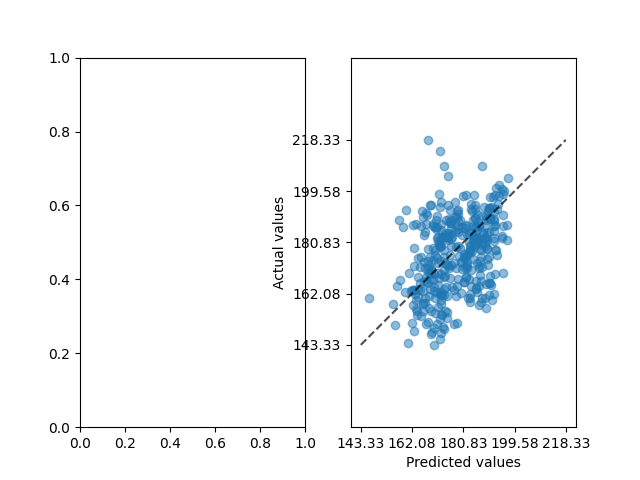

In [27]:
error_fig = ars_experiment.model.get_prediction_error_display(y=ars_experiment.dataset.y_test, y_pred=y_pred)
mlflow.log_figure(error_fig, 'errors.png')

ars_experiment.run_nb += 1
mlflow.end_run()

In [28]:
import xgboost as xgb

In [29]:
model: xgb.XGBRegressor = ars_experiment.model.best_estimator_
booster = model.get_booster()


In [30]:
print("Model Parameters:")
for param in model.get_xgb_params().keys():
    print(f"{param}: {model.get_xgb_params()[param]}")


Model Parameters:
objective: reg:squarederror
base_score: None
booster: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 0.7
device: cuda
eval_metric: None
gamma: 0.01
grow_policy: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: 5
monotone_constraints: None
multi_strategy: None
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.7
tree_method: None
validate_parameters: None
verbosity: 1


In [31]:
print("\nFeature Importances:")
print(model.feature_importances_)


Feature Importances:
[0.00051157 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00812452 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0053073
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00213614 0.0030455  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00103277 0.00391846 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00090611 0.         0.
 0.         0.         0.  

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

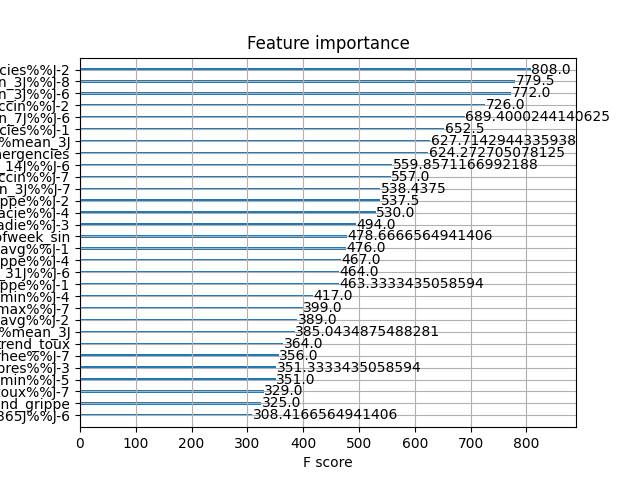

In [32]:
xgb.plot_importance(model, importance_type='cover', max_num_features=30)

<Axes: >

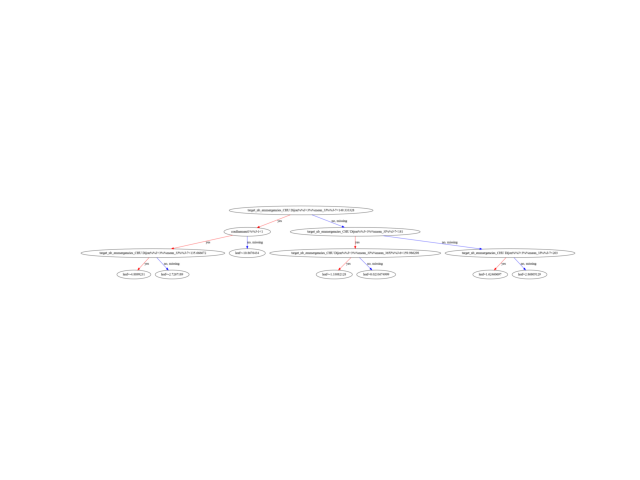

In [33]:
xgb.plot_tree(model)

In [34]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = booster.get_score(importance_type='gain')
importance_cover = booster.get_score(importance_type='cover')
importance_weight = booster.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
# print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])

In [35]:
import matplotlib.pyplot as plt

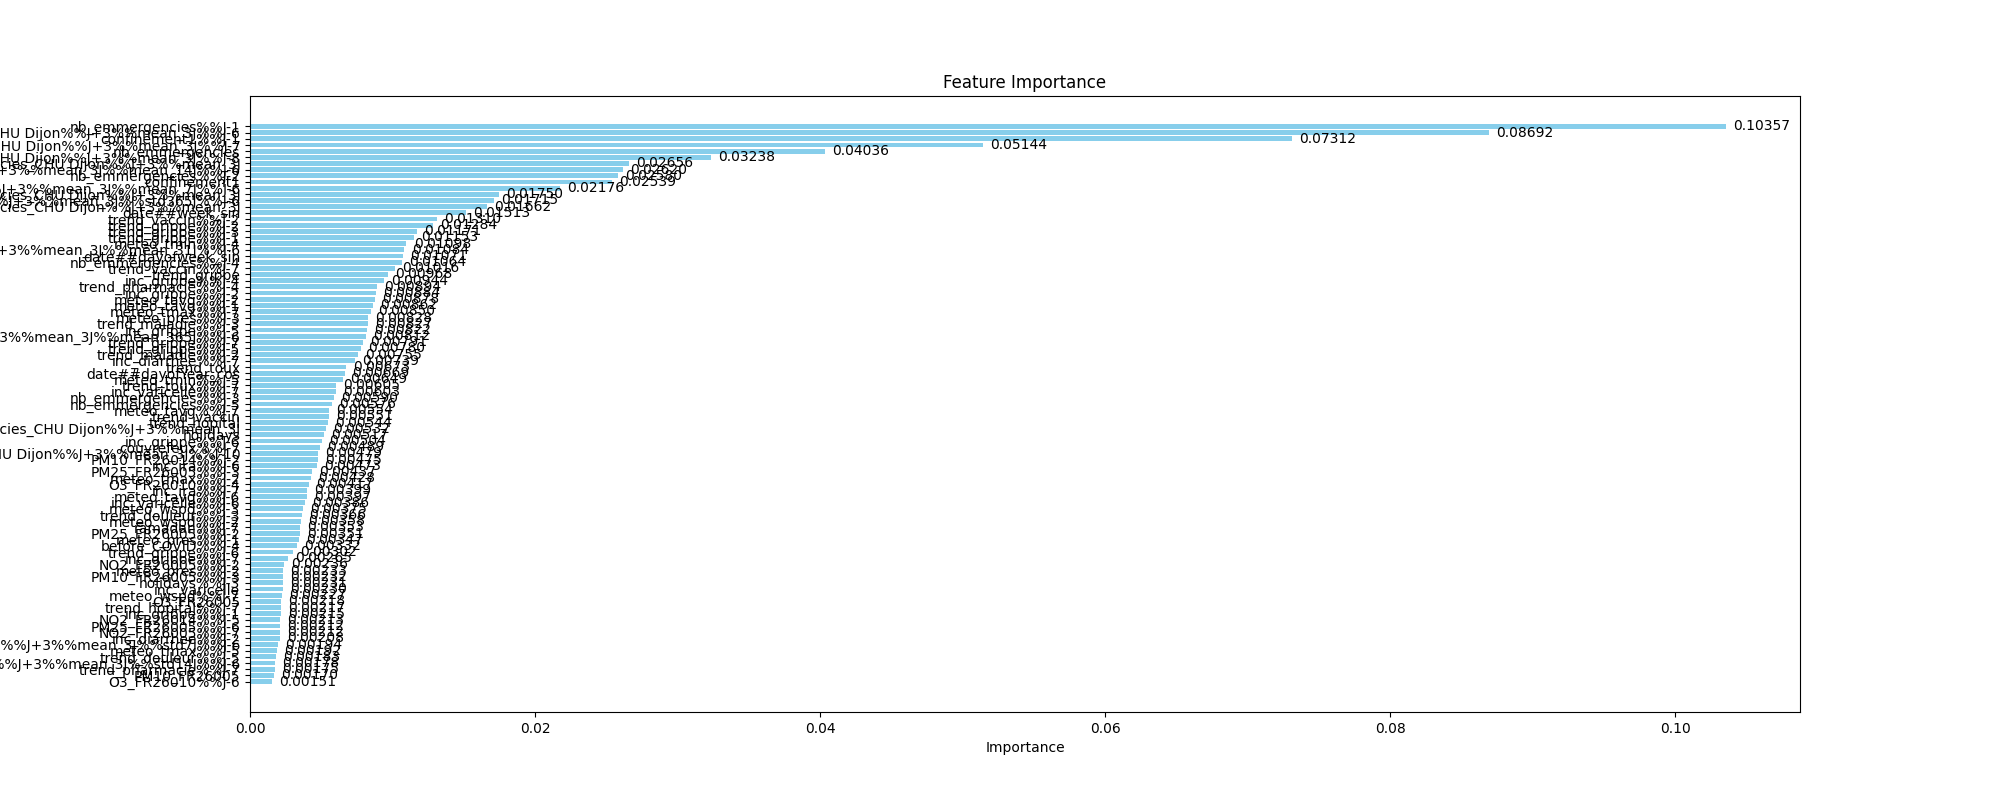

In [36]:
# Assuming your DataFrame is named `df`
# Sort features by importance
df_sorted = df.sort_values(by='importance', ascending=True)

# # Select only the 30 first features (based on sorted order)
# df_sorted = df_sorted.nlargest(30, 'importance')

# Plotting the horizontal bar chart
plt.figure(figsize=(20, 8))
plt.barh(df_sorted['feature'], df_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Adding the importance values next to each bar
for index, value in enumerate(df_sorted['importance']):
    plt.text(value + 0.0005, index, f'{value:.5f}', va='center')

plt.show()

In [37]:
df_sorted

,feature,gain,cover,weight,gain_norm,cover_norm,weight_norm,importance,rank
90,O3_FR26010%%J-6,1096.582520,12.000000,1.0,0.001033,0.000529,0.004184,0.001512,91.0
89,PM10_FR26005,969.465088,31.000000,1.0,0.000913,0.001366,0.004184,0.001703,90.0
88,trend_pharmacie%%J-7,639.720703,46.000000,1.0,0.000602,0.002027,0.004184,0.001746,89.0
87,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...,930.375000,38.000000,1.0,0.000876,0.001675,0.004184,0.001777,88.0
86,trend_douleur%%J-5,881.366211,44.000000,1.0,0.000830,0.001939,0.004184,0.001834,87.0
...,...,...,...,...,...,...,...,...,...
4,nb_emmergencies,48636.902344,624.272705,11.0,0.045806,0.027511,0.046025,0.040361,5.0
3,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...,65689.984375,538.437500,16.0,0.061867,0.023728,0.066946,0.051441,4.0
2,confinement1%%J-1,149319.093750,149.000000,1.0,0.140629,0.006566,0.004184,0.073121,3.0
1,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...,148688.015625,772.000000,8.0,0.140035,0.034021,0.033473,0.086918,2.0


In [38]:
df_sorted.to_csv("feature_importance.csv")

In [39]:
X_train = ars_experiment.dataset.enc_X_train
X_test = ars_experiment.dataset.enc_X_test
X_val = ars_experiment.dataset.enc_X_val

y_train = ars_experiment.dataset.y_train
y_test = ars_experiment.dataset.y_test
y_val = ars_experiment.dataset.y_val

In [40]:
ars_experiment.predict_at_horizon(ars_experiment.dataset, 3)

meteo_wspd%%J-7                                                  -1.006750
trend_rhume%%J-6                                                 -0.098181
trend_SAMU%%J-3                                                  -0.081327
O3_FR26005%%J-2                                                  -0.805563
trend_infection respiratoire                                     -0.029348
                                                                   ...    
target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6    200.095238
nb_emmergencies%%J-7                                            202.000000
target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6     21.963898
nb_emmergencies%%J-5                                            202.000000
nb_accidents%%J-7                                                 0.000000
Name: 2019-01-03T00:00:00.000000000, Length: 792, dtype: float64


XGBoostError: [12:51:23] /workspace/src/predictor/gpu_predictor.cu:981: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 792) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x743466c2dbbc]
  [bt] (1) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xc9a933) [0x74346769a933]
  [bt] (2) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xc9c639) [0x74346769c639]
  [bt] (3) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x57c309) [0x743466f7c309]
  [bt] (4) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x5cfff9) [0x743466fcfff9]
  [bt] (5) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x87f36a) [0x74346727f36a]
  [bt] (6) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromCudaArray+0xb2) [0x7434672800f2]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x74356ce33e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x74356ce30493]



In [41]:
import shap
shap.initjs()
explainer = explainer_xgb = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

XGBoostError: [13:24:45] /workspace/src/c_api/../common/device_helpers.cuh:400: Memory allocation error on worker 0: std::bad_alloc: cudaErrorUnknown: unknown error
- Free memory: 7975731200
- Requested memory: 3685864

Stack trace:
  [bt] (0) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x743466c2dbbc]
  [bt] (1) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x8a95c6) [0x7434672a95c6]
  [bt] (2) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x8fac4a) [0x7434672fac4a]
  [bt] (3) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x929a6e) [0x743467329a6e]
  [bt] (4) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xcb503b) [0x7434676b503b]
  [bt] (5) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x5900e6) [0x743466f900e6]
  [bt] (6) /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDMatrix+0x2a8) [0x743466b3bae8]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x74356ce33e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x74356ce30493]



In [ ]:
shap.plots.beeswarm(shap_values=shap_values)

In [ ]:
shap.plots.force(explainer_xgb.expected_value, shap_values)

In [ ]:
# Run the experiment
# ars_experiment.run(dataset_config=get_dataset_config, model_config=model_config, find_best_features=True)

In [ ]:
# y_pred = ars_experiment.predict(ars_experiment.dataset)
# y_true = ars_experiment.dataset.y_test

In [ ]:
# ars_experiment.model.get_prediction_error_display(y_true, y_pred)

In [ ]:
# X_train.to_csv("X_train.csv", index=False)
# X_test.to_csv("X_test.csv", index=False)
# X_val.to_csv("X_val.csv", index=False)
# y_train.to_csv("y_train.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

In [ ]:
# model = ars_experiment.model

In [ ]:
# dataset = arsTabularDataset

In [ ]:
# dataset.enc_data.head()

In [ ]:
# df = dataset.enc_data
# df

In [ ]:
# from scipy.cluster import hierarchy
# from scipy.spatial.distance import squareform
# from scipy.stats import spearmanr
# import matplotlib.pyplot as plt
# import numpy as np

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# corr = spearmanr(X).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

In [ ]:
# from shap_select import shap_select

In [ ]:
# selected_features_df = shap_select(model.best_estimator_, X_val, y_val, task="regression", threshold=0.05)

In [ ]:
# X_train

In [ ]:
# bst = model.best_estimator_.get_booster()

In [ ]:
# importance_gain = bst.get_score(importance_type='gain')
# importance_cover = bst.get_score(importance_type='cover')
# importance_weight = bst.get_score(importance_type='weight')

In [ ]:
# df_cover = pd.DataFrame(importance_cover, index=[0]).T
# df_gain = pd.DataFrame(importance_gain, index=[0]).T
# df_weight = pd.DataFrame(importance_weight, index=[0]).T

In [ ]:
# df_cover.shape

In [ ]:
# df_cover.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_gain.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_weight.sort_values(by=0).plot(kind="barh", figsize=(15,20))

In [ ]:
# model.shapley_additive_explanation(X_test, outname='shap_b', dir_output='.', mode="beeswarm", figsize=(50, 25))

In [ ]:
# from collections import defaultdict

# cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# selected_features_names = X.columns[selected_features]
# X_train_sel = X_train[selected_features_names]
# X_test_sel = X_test[selected_features_names]
# X_val_sel = X_val[selected_features_names]
# model_config['fit_params'].update({'eval_set': [(X_val_sel, y_val[target]) for target in ars_experiment.dataset.targets_names]})
# model.fit(X_train_sel, y_train, **model_config)
# print(
#     "Baseline accuracy on test data with features removed:"
#     f" {model.score(X_test_sel, y_test):.2}"
# )


In [ ]:
# import matplotlib

# from sklearn.inspection import permutation_importance
# from sklearn.utils.fixes import parse_version


# def plot_permutation_importance(clf, X, y, ax):
#     result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
#     perm_sorted_idx = result.importances_mean.argsort()

#     # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
#     # renamed to `tick_labels`. The following code handles this.
#     tick_labels_parameter_name = (
#         "tick_labels"
#         if parse_version(matplotlib.__version__) >= parse_version("3.9")
#         else "labels"
#     )
#     tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
#     ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
#     ax.axvline(x=0, color="k", linestyle="--")
#     return ax


In [ ]:
# fig, ax = plt.subplots(figsize=(7, 6))
# plot_permutation_importance(model, X_test_sel, y_test, ax)
# ax.set_title("Permutation Importances on selected subset of features\n(test set)")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()
# plt.show()

In [ ]:
# get the first line of x train
# X_train_sel[:1]

In [ ]:
# y_train[:1]

In [ ]:
# model.predict(X_train_sel[:1])

In [ ]:
# import shap
# shap.initjs()
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)
# single_explanation = explainer_xgb.shap_values(X_train_sel[:1])
# shap.summary_plot(single_explanation, X_test_sel, plot_type="bar")


In [ ]:
# X_train.columns

In [ ]:
# model = ars_experiment.model

In [ ]:
# X_train = ars_experiment.dataset.enc_X_train
# X_test = ars_experiment.dataset.enc_X_test
# X_val = ars_experiment.dataset.enc_X_val

# y_train = ars_experiment.dataset.y_train
# y_test = ars_experiment.dataset.y_test
# y_val = ars_experiment.dataset.y_val

In [ ]:
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)

In [ ]:
# single_explanation = explainer_xgb.shap_values(X_train[:1])

In [ ]:
# shap_values_xgb = explainer_xgb.shap_values(X_test[:50])

In [ ]:
# shap.dependence_plot('inc_grippe', shap_values_xgb, X_train_sel)

In [ ]:
# shap_values_xgb